# 6 Hour Forecast using Dynamic Graph

In [7]:
%matplotlib ipympl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
import pickle # to access dataframe faster than csv
import glob, re
import os
import csv
from pathlib import Path
import scipy as sp
import networkx
import torch_geometric
import torch
from torch_geometric.utils.convert import from_networkx

# for tweaked_TAGConv 
import torch.nn as nn
from torch import Tensor
from torch_geometric.data import Data
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.conv.gcn_conv import gcn_norm # adjacency matrix normalization
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.nn.inits import zeros # initialize weights and biases for nn
from torch_geometric.typing import Adj, OptTensor, SparseTensor
from torch_geometric.utils import spmm # for sparse matrix multiplication

## Initialize
1. Aggregated (dataframe available at https://drive.google.com/drive/folders/1CwSLAJeCGUuHXRJOZ9YgkraHYaE8pGGH?usp=sharing)
2. Load aggregated
3. Load window csv with lclids corresponding to aggregated data

In [8]:
# load the data
file = open('uk_smart_meter_aggregated/df_agg.pkl','rb')
df_agg = pickle.load(file)
df_agg.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17544 entries, 2012-01-01 00:00:00 to 2013-12-31 23:00:00
Columns: 5558 entries, 2 to 5564
dtypes: float64(5558)
memory usage: 744.1 MB


In [9]:
file = open('uk_smart_meter_aggregated/windows_agg_ids.pkl','rb')
windows = pickle.load(file)
windows.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5558 entries, 0 to 5557
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype          
---  ------       --------------  -----          
 0   LCLid        5558 non-null   int64          
 1   Enabled At   5558 non-null   datetime64[ns] 
 2   Disabled At  5558 non-null   datetime64[ns] 
 3   Duration     5558 non-null   timedelta64[ns]
dtypes: datetime64[ns](2), int64(1), timedelta64[ns](1)
memory usage: 217.1 KB


## Snapshot-based temporal graph
Idea: Build the adjacency matrix for all nodes using `create_adjacency_matrix`. Select a time-stamp for example [0]: '2012-01-01 00:00:00' or [1]: '2012-01-01 01:00:00' and so on. For this time-stamp what all nodes are active? Make an adjacency matrix for only these nodes for that particular time stamp using `get_snapshot_adjacency`. This function further returns the LCLids of active nodes (2,3,... 5564) and the indices of those active nodes (dataframe indices as in from range 0 to 5557).

1. Get the adjacency matrix for *all the nodes* at once to avoid computation

Number of unique start dates:  2154
Graph connected for k=50: True
sparsity:  0.9439180477754235


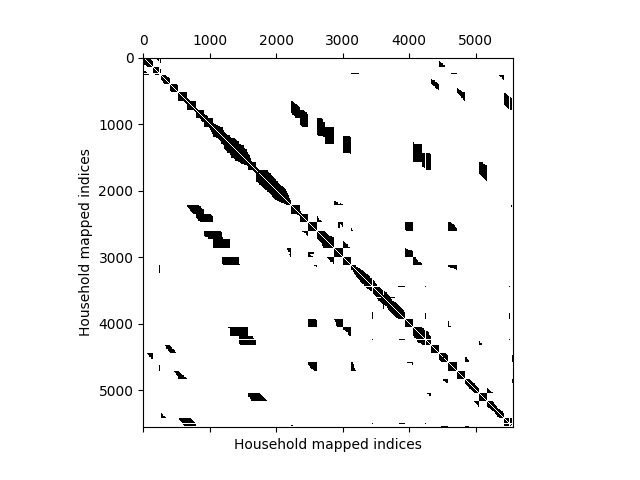

In [10]:
def create_adjacency_matrix(lclids, k):
    number_of_nodes = sum([len(l) for l in lclids])
    adjacency_matrix = np.zeros((number_of_nodes, number_of_nodes))
    # Create the graph by iterating over the list of lists of LCLids
    # and connecting all nodes in the list with each other
    # and with the k-nearest lists
    for i in range(len(lclids)): # range 2156
        for j in range(len(lclids)): # range 2156 
            if i == j: 
                for lclid in lclids[i]:
                    for lclid2 in lclids[j]:
                        adjacency_matrix[lclid, lclid2] = 1
            elif abs(i-j) <= k:
                for lclid in lclids[i]:
                    for lclid2 in lclids[j]:
                        adjacency_matrix[lclid, lclid2] = 1
    adjacency_matrix = adjacency_matrix - np.eye(number_of_nodes)
    return sp.sparse.bsr_array(adjacency_matrix)
    
# Sort rows by start date
windows_copy = windows.sort_values(by='Enabled At').copy()

# Get an ordered list of dates 'Enabled At'
enable_unique_dates = windows_copy['Enabled At'].unique()

# Get a list of lists of LCLids that have the same start date
nbor_lclids = [windows_copy[windows_copy['Enabled At'] == date].index.tolist() for date in enable_unique_dates]
print('Number of unique start dates: ', len(enable_unique_dates))
assert len(windows) == sum([len(l) for l in nbor_lclids])

# K-nearest neighbours
k = 50

adjacency_matrix = create_adjacency_matrix(nbor_lclids, k)
# Compute the sparsity of the adjacency matrix
sparsity = 1 - sp.sparse.bsr_matrix.count_nonzero(adjacency_matrix) / np.prod(adjacency_matrix.shape)
G = networkx.from_scipy_sparse_array(adjacency_matrix)
print(f'Graph connected for k={k}: {networkx.is_connected(G)}')
print('sparsity: ', sparsity)

plt.spy(sp.sparse.bsr_matrix.toarray(adjacency_matrix))
plt.xlabel("Household mapped indices"), plt.ylabel("Household mapped indices")
# save the adjacency matrix
np.save('Results/adjacency_matrix.npy', adjacency_matrix)
plt.show()

2. Make a function to get the sub-adjacency matrix for all nodes active at a given time instant

In [14]:
def get_snapshot_adjacency(timestampidx, full_adjacency_matrix, df_agg):
    """
    timestampidx: Time index; For example [0]: '2012-01-01 00:00:00'
    full_adjacency_matrix (np.array()): adjacency matrix for all the LCLids
    df_agg: aggregated dataframe with timeseries for all LCLids 
    
    Returns:
    indices_active_nodes: dataframe indices of active nodes
    active nodes: LCLids of active nodes 
    active_sparse_submat: adjacency matrix obtained for that particular timestamp (using timestampidx)
    """
    full_adjacency_matrix = full_adjacency_matrix.toarray()

    # get all the active nodes for that particular time-stamp
    active_nodes = df_agg.columns[df_agg.loc[df_agg.index[timestampidx], :].notna()]
    
    # indices of active nodes
    indices_active_nodes = windows[windows['LCLid'].isin(active_nodes.values)].index

    # active nodes sub-adjacency matrix
    active_adj_submat = full_adjacency_matrix[np.ix_(indices_active_nodes, indices_active_nodes)]

    if active_adj_submat.shape[0] != active_nodes.shape[0]:
        print(f'# active nodes = {active_nodes.shape}, while \
        Adjacency Matrix Shape = {active_adj_submat.shape}')
        raise RuntimeError()

    # create graph from the adjacency submatrix to check if it is connected
    active_sparse_submat = sp.sparse.bsr_array(active_adj_submat)
    
    G = networkx.from_scipy_sparse_array(active_sparse_submat)

    # check if the graph is fully connected
    assert networkx.is_connected(G)

    # FOR FURTHER ANALYSIS
    #sparsity_submat = 1 - sp.sparse.bsr_matrix.count_nonzero(active_sparse_submat) \
    #/ np.prod(active_sparse_submat.shape)
    #print(f'Sparsity = {sparsity_submat}')
    
    
    # get edge indices from the adjacency submatrix COO Format
    edge_index = torch.tensor(np.array(G.edges).T)

    # node feature matrix 
    node_feat = torch.tensor(df_agg.loc[df_agg.index[timestampidx],active_nodes].values).view(-1,1)
    return indices_active_nodes, active_nodes, active_sparse_submat, node_feat, edge_index


# example usage:
indices, activenodes, active_sparse_submat, node_feat, edge_idx = get_snapshot_adjacency(0, adjacency_matrix, df_agg) # check exact date using df_agg.index[100]

### Align snapshots

Idea: Take snapshots for a window and extract the sub-adjacency matrices (only considering active nodes) and node features. And stack these sub-adjacency matrices as a dictionary (book).

In [15]:
# print(f'Snapshots taken at {df_agg.index[0]}, {df_agg.index[50]}, {df_agg.index[100]} to calculate the supra adjacency matrix')
def get_subadj_book(window_idx, adjacency_matrix, df_agg):
    """
    Input: 
        - window_idx:       window index (for eg., range(0,23) for first 24 hours)
        - adjacency_matrix: full adjacency matrix 
        - df_agg:           aggregated dataframe 
    Returns 
        - idx_book:       dict of indices (of dataframe) of all active nodes throughout the window for all time instances
        - actnod_book:    dict of LCLids of active nodes throughout the window for all time instances
        - subadj_book:    dict of subadjacency matrices throughout the window for all time instances (can be of different sizes)
        - all_nodes:      set of LCLids of all active unique nodes inside the window_idx
        - node_feat_book: dict of node feature matrix throughout the window for all instances
        - edge_idx_book:  dict of edge index throughout the window for all instances
    """
    node_feat_book = {}
    edge_idx_book = {}
    subadj_book = {}
    idx_book = {}
    actnod_book = {}
    all_nodes = {}
    for i, idx in enumerate(window_idx):
        # extract the subadjacency matrix at i-th time-stamp
        idx_i, actnod_i, subadj_i, node_feat_i, edge_idx_i = get_snapshot_adjacency(idx, adjacency_matrix, df_agg)
        idx_book[i] = idx_i
        actnod_book[i] = actnod_i
        subadj_book[i] = subadj_i.toarray()
        node_feat_book[i] = node_feat_i
        edge_idx_book[i] = edge_idx_i
        
        # Union of nodes in all snapshots
        # EX: snapshot 1 nodes: {3,2,1}; snapshot 2 nodes: {2,3,4}; snapshot 3 nodes: {1,5,6}
        # all nodes = {3,2,1,4,5,6}
        all_nodes = set(all_nodes).union(set(actnod_i))
    return idx_book, actnod_book, subadj_book, all_nodes, node_feat_book, edge_idx_book

window_idx = 100*np.array([0,1,2,3,4,5,6,7,8,9,10])# np.arange(24) #100*np.array([0,1,2,3,4,5,6,7,8,9,10]) # training window
# extract the subadjacency matrix for all those time-stamps
idx_book, actnod_book, subadj_book, all_nodes, node_feat_book, edge_idx_book = get_subadj_book(window_idx, adjacency_matrix, df_agg)

Align the snapshots of different adjacency matrices to become size compatible. For example snapshot 1 has $R^{410\times410}$, snapshot 2 has $R^{450\times 450}$. This means that first snapshot has 410 active nodes and second snapshot has 450 active nodes. So, make a union set of all these nodes and "align" the shape of snapshot 2 adjacency matrix, node-features and edge_index to the shape of snapshot 2. So, snapshot 1 will also have adjacency matrix of size $R^{450\times 450}$ but with zeros at entries corresponding to the node that is not active in that snapshot 1.

In [17]:
def align_adjacency_matrix(active_nodes, subadj, all_nodes, node_index_map):
    """
    Input: 
        - active_nodes: list of active nodes 
        - subadj: sub-adjacency matrix for these active nodes
        - all_nodes: all the nodes for the entire window not just the instant where subadj and active_nodes are found
        - node_index_map: sorted all_nodes with {index: node...} 
        

    """
    if not isinstance(subadj, np.ndarray):
        subadj = subadj.toarray()
    aligned_subadj = np.zeros((len(all_nodes), len(all_nodes)))
    for i, node_i in enumerate(active_nodes):
        for j, node_j in enumerate(active_nodes):
            if node_i in node_index_map and node_j in node_index_map:
                idx_i = node_index_map[node_i]
                idx_j = node_index_map[node_j]
                aligned_subadj[idx_i, idx_j] = subadj[i, j]
    return aligned_subadj


def get_aligned_adj_book(subadj_book, node_feat_book, actnod_book, all_nodes):
    
    # create node index mapping
    # for ex., index_mapping = {0,1,2,3,4,5} for sorted nodes {1,2,3,4,5,6}
    node_index_map = {node: i for i, node in enumerate(sorted(all_nodes))} # node: idx dictionary

    # total nodes 
    num_nodes = len(node_index_map)

    aligned_adj_book = {}
    aligned_node_feat_book = {}
    aligned_edge_index_book = {}

    for i, ((actkey, actnod), (subadjkey, subadj)) in enumerate(zip(actnod_book.items(), subadj_book.items())):
        #print(actkey, actnod), print(subadjkey, subadj)
        aligned_adj_book[i] = align_adjacency_matrix(actnod, subadj, all_nodes, node_index_map)
        # G = networkx.from_scipy_sparse_array(sp.sparse.bsr_array(aligned_adj_book[i]))
        # aligned_edge_index_book[i] = torch.tensor(np.array(G.edges).T)
        
        # Extract the indices of the non-zero elements (edges)
        row_indices, col_indices = np.nonzero(aligned_adj_book[i])

        # Combine the row and column indices to form the edge_index
        aligned_edge_index_book[i] = torch.tensor(np.vstack((row_indices, col_indices)))
        
        for j, key in enumerate(actnod.values):
            temp = np.zeros((len(all_nodes), 1))
            temp[node_index_map[key]] = node_feat_book[actkey][j]
        aligned_node_feat_book[i] = temp
    return aligned_adj_book, node_index_map, aligned_node_feat_book, aligned_edge_index_book

aligned_adj_book, node_index_map, aligned_node_feat_book, aligned_edge_index_book = get_aligned_adj_book(subadj_book, node_feat_book, actnod_book, all_nodes)

### Graph-VAR

$$
\mathbf{x_t} = -\sum_{p=1}^{P} \sum_{k=0}^{K} h_{kp}\mathbf{S}_{t-p}^k \mathbf{x}_{t-p} 
$$

where P in our case will be 24. 

In [ ]:
class TemporalGraphDataset: # Add data for training
    def __init__(self):
        self.graph_data = []

    def add_time_instance(self, node_features, edge_index):
        edge_index, edge_weight = gcn_norm(edge_index=edge_index.long(),
                                           edge_weight=None, 
                                           num_nodes=node_features.shape[0],
                                           add_self_loops=False)
        data = Data(x=torch.tensor(node_features).float(), edge_index=edge_index.float(), edge_weight = edge_weight)
        self.graph_data.append(data)

    def get_time_instance(self, time):
        return self.graph_data[time]
        
# Create the dataset
dataset = TemporalGraphDataset()

for i,_ in enumerate(window_idx):
    # features
    # x_idx = torch.tensor(df_agg.loc[df_agg.index[i],actnod_book[i]].values).view(-1,1)
    dataset.add_time_instance(aligned_node_feat_book[i], aligned_edge_index_book[i])


In [ ]:
dataset.get_time_instance(0)

In [ ]:
class TemporalGCNLayer(MessagePassing):
    def __init__(self, in_channels: int, out_channels: int, K: int, P: int, normalize: bool = True): # P from window_idx = np.arange(P)
        super(TemporalGCNLayer, self).__init__(aggr = 'add') # 'Add' aggregation
        self.K = K
        self.P = P
        # self.normalize = normalize
        # self.linear = nn.Linear(in_channels, out_channels)
        self.h = nn.Parameter(torch.Tensor(K+1, P)) # depends on the order of filter and P
        self.reset_parameters() # initialize parameters
        
    def reset_parameters(self):
        #nn.init.xavier_uniform_(self.linear.weight) # initialize the weight of the linear layer
        #nn.init.zeros_(self.linear.bias)
        nn.init.xavier_uniform_(self.h)

    def forward(self, dataset) -> Tensor:
        out = torch.zeros_like(dataset.get_time_instance(0).x) # out dim = (410,1)
        for p in range(0, self.P):      # 1 to P but indexing in python
            for k in range(self.K + 1): # 0 to K
                h_kp = self.h[k, p-1]   # access the [k, p-1] parameter from parameter matrix
                edge_index = dataset.get_time_instance(p).edge_index.long()
                edge_weight = dataset.get_time_instance(p).edge_weight
                adj_sparse_tensor = SparseTensor(row = edge_index[0], col = edge_index[1], value=edge_weight)
                # print(isinstance(adj_matrix, torch.FloatTensor))
                x_t_minus_p = dataset.get_time_instance(p).x
                out += h_kp * self.propagate(adj_sparse_tensor, x = x_t_minus_p, k = k)
        return out # self.linear(out) # here equals out

    def message(self, x_j, edge_weight): # not needed in our case
        return edge_weight.view(-1,1) * x_j 

    def propagate(self, adj_sparse_tensor, x = None, k = 1):
        x_out = x
        for _ in range(k):
            x_out = adj_sparse_tensor.matmul(x_out)
        return x_out 

class TemporalGCN(nn.Module):
    def __init__(self, in_channels, out_channels, K, P):
        super(TemporalGCN, self).__init__()
        self.gcn_layer = TemporalGCNLayer(in_channels, out_channels, K, P)

    def forward(self, dataset):
        return self.gcn_layer(dataset)

# Initialize the model
in_channels = 1 # 1 feature
out_channels = 1 # 1 feature
K = 2 # order of polynomial filter
P = len(window_idx)
model = TemporalGCN(in_channels, out_channels, K, P)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)
criterion = nn.MSELoss()

In [ ]:
# count the number of parameters to verify 
# for K = 2, P = 3, no. of parameters = 9
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
num_params = count_parameters(model)
print(f'The model has {num_params} parameters')

In [ ]:
def get_target(window_idx, all_nodes):
    target_timestamp = window_idx[-1]
    # get target values for all the nodes active for training 
    target = torch.tensor(df_agg.loc[df_agg.index[target_timestamp],list(all_nodes)].values).view(-1,1).float()
    return target

# Training Loop
num_epochs = 2000
target = get_target(window_idx, all_nodes)
train_losses = []
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass 
    predict = model(dataset)

    loss = criterion(predict, target)
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    if (epoch+1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
print("Training Finished!")


In [ ]:
fig, ax = plt.subplots()
ax.plot(train_losses)

## Below part is not useful but kept for backup.

### Build the supra-adjacency matrix $S_\diamond$ from all the aligned subadjacency matrices "book" $\$_i$ 
Build a supra-adjacency matrix for $n$ time instances using spatio-temporal coupling. Note: we cannot use the kronecker product here since at all instances, the adjacnecy matrix `aligned_subadj1/2/3` is different. 

In [ ]:
def supra_adjacency_matrix(aligned_subadj_book):

    # convert the dict to stack 
    stacked_aligned_subadj = np.stack(list(aligned_book.values()), axis = -1)
    
    # time instances
    instances = stacked_aligned_subadj.shape[2]

    # size of aligned
    a_size = stacked_aligned_subadj.shape[0]

    # supra 
    S = np.zeros((a_size*instances, a_size*instances))

    # Place aligned at appropriate locations for spatio-temporal coupling
    # temporal + own-node spatial component
    for i in range(1,instances):
        S[i*a_size:(i+1)*a_size, (i-1)*a_size:i*a_size] = stacked_aligned_subadj[...,i-1] + np.eye(a_size) # last term is own-node spatial component
    # spatial coupling
    for i in range(instances):
        S[i*a_size:(i+1)*a_size, i*a_size:(i+1)*a_size] = stacked_aligned_subadj[...,i]
    
    return S

supra_adj_mat = supra_adjacency_matrix(aligned_book)

In [ ]:
fig, ax = plt.subplots()
plt.spy(supra_adj_mat)
plt.show()

### Imputation on Supra-adjacency matrix/Product Graph

In [ ]:
len(all_nodes)*len(window_idx)

In [ ]:
# fill the y_diamond using data
y_diamond = np.zeros([len(all_nodes)*len(actnod_book), 1])

# the index with corresponding lclid will get the data

# 6th LCLid 
y_diamond[0] = df_agg.loc[df_agg.index[window_idx[0]],list(all_nodes)[0]] 
# 16th LCLid
y_diamond[1] = df_agg.loc[df_agg.index[window_idx[1]], list(all_nodes)[1]]
